In [3]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('./heart_attack_indonesia.csv')
df.head()

,age,gender,region,income_level,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,...,blood_pressure_diastolic,fasting_blood_sugar,cholesterol_hdl,cholesterol_ldl,triglycerides,EKG_results,previous_heart_disease,medication_usage,participated_in_free_screening,heart_attack
0,60,Male,Rural,Middle,0,1,211,0,83,0,...,62,173,48,121,101,Normal,0,0,0,0
1,53,Female,Urban,Low,0,0,208,0,106,1,...,76,70,58,83,138,Normal,1,0,1,0
2,62,Female,Urban,Low,0,0,231,1,112,1,...,74,118,69,130,171,Abnormal,0,1,0,1
3,73,Male,Urban,Low,1,0,202,0,82,1,...,65,98,52,85,146,Normal,0,1,1,0
4,52,Male,Urban,Middle,1,0,232,0,89,0,...,75,104,59,127,139,Normal,1,0,1,1


Count of missing alcohol_consumption: 0
Count of non-missing alcohol_consumption: 158355
Group summary (missing vs non-missing alcohol_consumption):
                   age        income_level hypertension  diabetes  \
                  mean median     <lambda>         mean      mean   
alc_missing                                                         
False        54.543778   55.0       Middle     0.299069  0.199804   

            cholesterol_level heart_attack  
                         mean         mean  
alc_missing                                 
False              199.533264     0.401004  


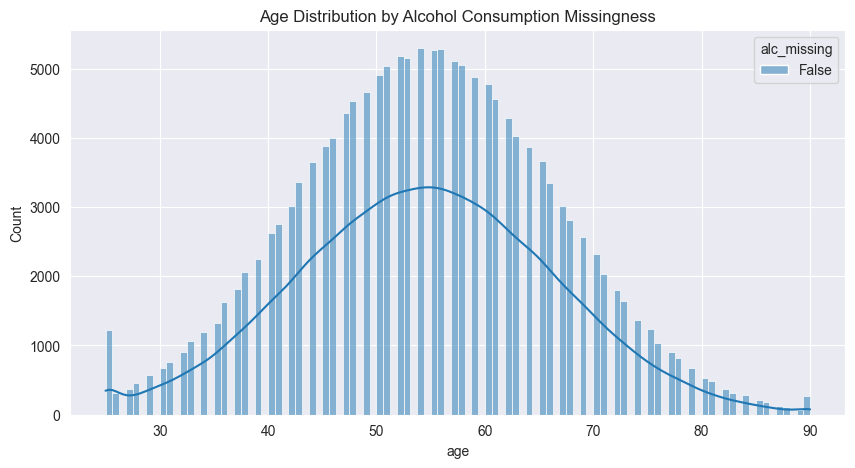

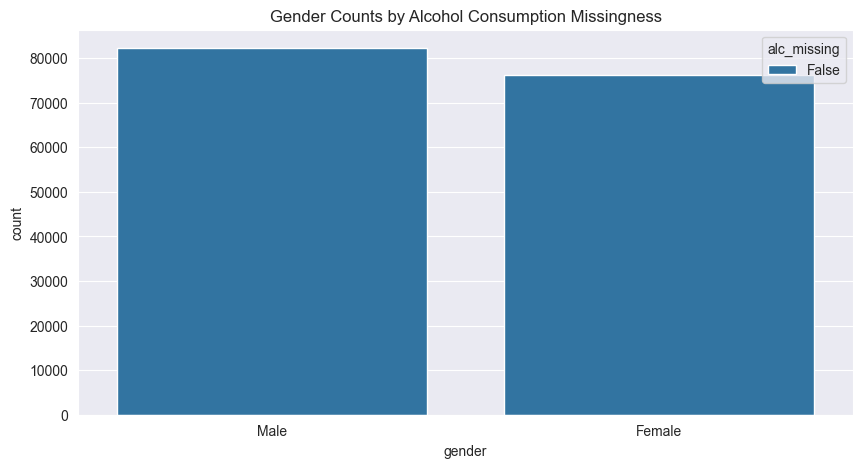

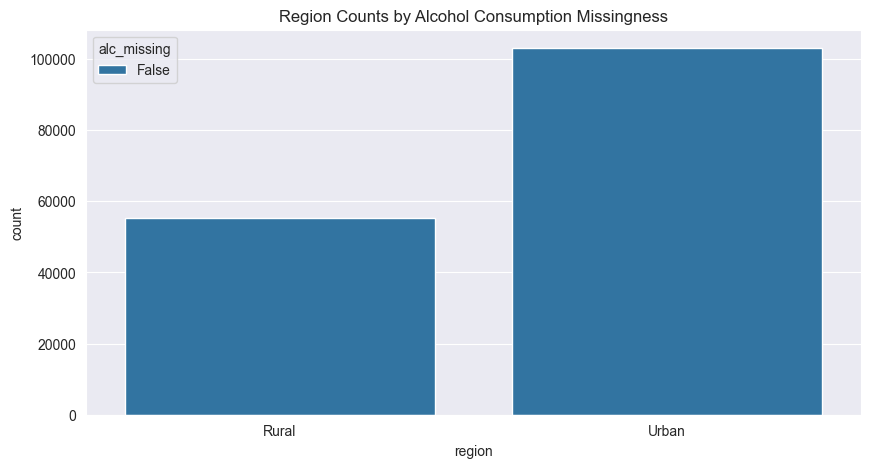

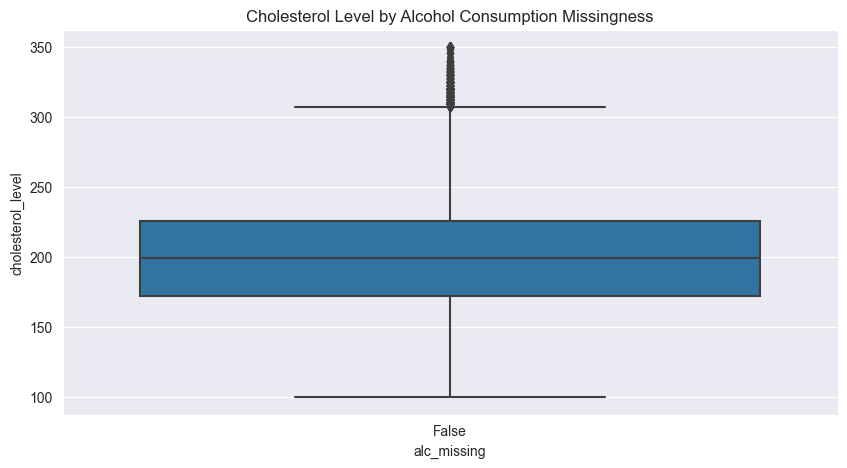

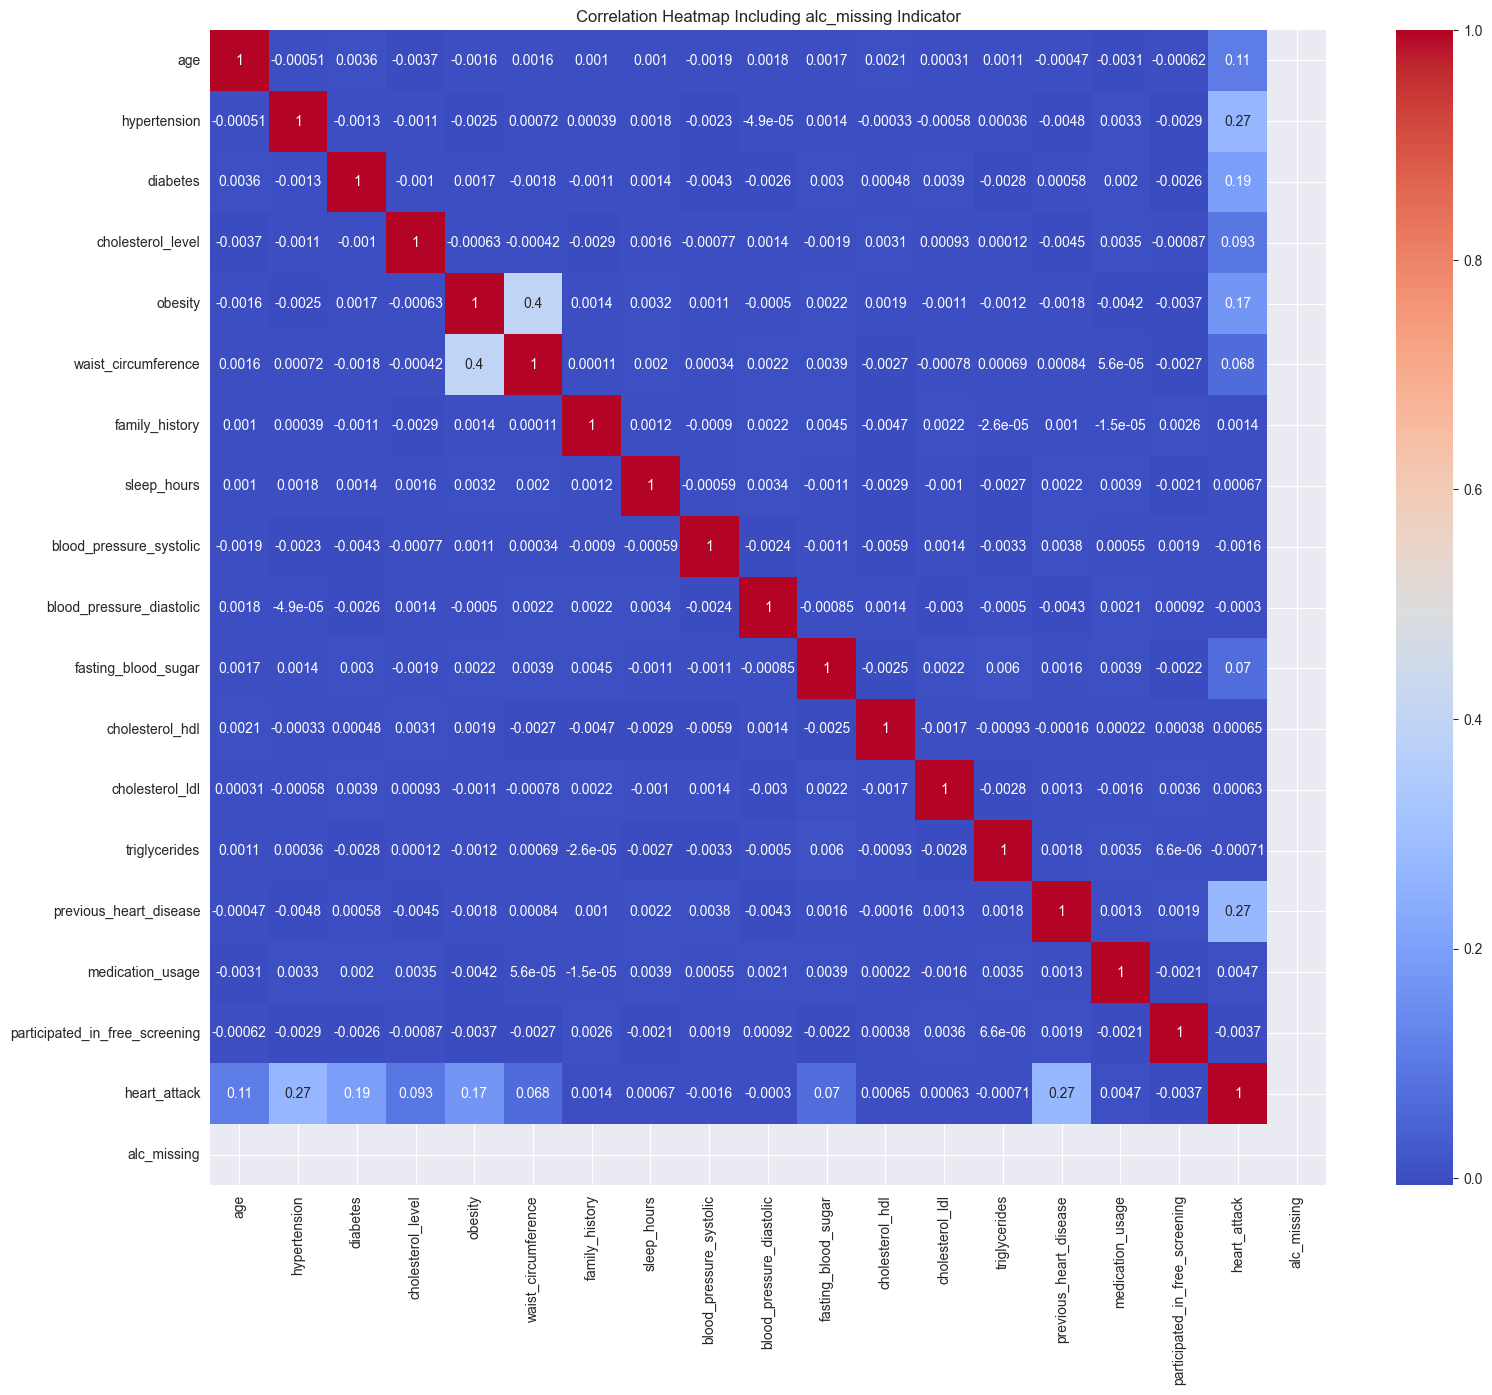

In [5]:
df['alc_missing'] = df['alcohol_consumption'].isnull()
print("Count of missing alcohol_consumption:", df['alc_missing'].sum())
print("Count of non-missing alcohol_consumption:", (~df['alc_missing']).sum())
grouped = df.groupby('alc_missing').agg({
    'age': ['mean','median'],
    'income_level': lambda x: x.mode()[0],
    'hypertension': 'mean',
    'diabetes': 'mean',
    'cholesterol_level': 'mean',
    'heart_attack': 'mean'
})
print("Group summary (missing vs non-missing alcohol_consumption):")
print(grouped)
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='age', hue='alc_missing', kde=True, multiple='stack')
plt.title("Age Distribution by Alcohol Consumption Missingness")
plt.show()
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='gender', hue='alc_missing')
plt.title("Gender Counts by Alcohol Consumption Missingness")
plt.show()
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='region', hue='alc_missing')
plt.title("Region Counts by Alcohol Consumption Missingness")
plt.show()
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='alc_missing', y='cholesterol_level')
plt.title("Cholesterol Level by Alcohol Consumption Missingness")
plt.show()
corr = df.copy()
corr['alc_missing'] = corr['alc_missing'].astype(int)
numeric_cols = corr.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(18, 15))
sns.heatmap(corr[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap Including alc_missing Indicator")
plt.show()

In [6]:
df = df.drop(columns=['alcohol_consumption','alc_missing'])
print("Shape after dropping alcohol_consumption:", df.shape)
print("First 5 records after dropping alcohol_consumption and alc_missing:")
print(df.head())

Shape after dropping alcohol_consumption: (158355, 27)
First 5 records after dropping alcohol_consumption and alc_missing:
   age  gender region income_level  hypertension  diabetes  cholesterol_level  \
0   60    Male  Rural       Middle             0         1                211   
1   53  Female  Urban          Low             0         0                208   
2   62  Female  Urban          Low             0         0                231   
3   73    Male  Urban          Low             1         0                202   
4   52    Male  Urban       Middle             1         0                232   

   obesity  waist_circumference  family_history  ... blood_pressure_diastolic  \
0        0                   83               0  ...                       62   
1        0                  106               1  ...                       76   
2        1                  112               1  ...                       74   
3        0                   82               1  ...              

In [7]:
cat_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [8]:
X = df.drop(columns=['heart_attack'])
y = df['heart_attack']
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (158355, 31)
y shape: (158355,)


In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_val_scaled shape:", X_val_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_scaled shape: (110848, 31)
X_val_scaled shape: (23753, 31)
X_test_scaled shape: (23754, 31)


In [10]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)
val_score = model.score(X_val_scaled, y_val)
test_score = model.score(X_test_scaled, y_test)
print("Validation Score:", val_score)
print("Test Score:", test_score)

Validation Score: 0.7332547467688292
Test Score: 0.7279195082933401


In [11]:
df['bp_diff'] = df['blood_pressure_systolic'] - df['blood_pressure_diastolic']
df['bp_ratio'] = df['blood_pressure_systolic'] / df['blood_pressure_diastolic']
df['ldl_hdl_ratio'] = df['cholesterol_ldl'] / df['cholesterol_hdl']
df['age_cholesterol'] = df['age'] * df['cholesterol_level']
df['bp_chol_interaction'] = df['blood_pressure_systolic'] * df['cholesterol_level']
df['fasting_sugar_ratio'] = df['fasting_blood_sugar'] / (df['age'] + 1)
df['waist_bp_interaction'] = df['waist_circumference'] * df['blood_pressure_systolic']
df['trig_to_chol_ratio'] = df['triglycerides'] / df['cholesterol_level']
df['sleep_age_interaction'] = df['sleep_hours'] * df['age']
df.head()

,age,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,sleep_hours,blood_pressure_systolic,blood_pressure_diastolic,...,EKG_results_Normal,bp_diff,bp_ratio,ldl_hdl_ratio,age_cholesterol,bp_chol_interaction,fasting_sugar_ratio,waist_bp_interaction,trig_to_chol_ratio,sleep_age_interaction
0,60,0,1,211,0,83,0,5.970603,113,62,...,1,51,1.822581,2.520833,12660,23843,2.836066,9379,0.478673,358.236190
1,53,0,0,208,0,106,1,5.643813,132,76,...,1,56,1.736842,1.431034,11024,27456,1.296296,13992,0.663462,299.122096
2,62,0,0,231,1,112,1,6.336197,116,74,...,0,42,1.567568,1.884058,14322,26796,1.873016,12992,0.740260,392.844194
3,73,1,0,202,0,82,1,7.912990,136,65,...,1,71,2.092308,1.634615,14746,27472,1.324324,11152,0.722772,577.648241
4,52,1,0,232,0,89,0,3.252338,127,75,...,1,52,1.693333,2.152542,12064,29464,1.962264,11303,0.599138,169.121584


In [12]:
X = df.drop(columns=['heart_attack'])
y = df['heart_attack']
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X head:", X.head())
print("y head:", y.head())

X shape: (158355, 40)
y shape: (158355,)
X head:    age  hypertension  diabetes  cholesterol_level  obesity  \
0   60             0         1                211        0   
1   53             0         0                208        0   
2   62             0         0                231        1   
3   73             1         0                202        0   
4   52             1         0                232        0   

   waist_circumference  family_history  sleep_hours  blood_pressure_systolic  \
0                   83               0     5.970603                      113   
1                  106               1     5.643813                      132   
2                  112               1     6.336197                      116   
3                   82               1     7.912990                      136   
4                   89               0     3.252338                      127   

   blood_pressure_diastolic  ...  EKG_results_Normal  bp_diff  bp_ratio  \
0                     

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_val_scaled shape:", X_val_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

model = LogisticRegression(max_iter=2500)
model.fit(X_train_scaled, y_train)
val_score = model.score(X_val_scaled, y_val)
test_score = model.score(X_test_scaled, y_test)
print("Validation Score:", val_score)
print("Test Score:", test_score)

X_train_scaled shape: (110848, 40)
X_val_scaled shape: (23753, 40)
X_test_scaled shape: (23754, 40)
Validation Score: 0.7319075485201869
Test Score: 0.7274143302180686


In [14]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('logistic', LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000))
])

In [15]:
model.fit(X_train_scaled, y_train)
val_score = model.score(X_val_scaled, y_val)
test_score = model.score(X_test_scaled, y_test)
print("Validation Score:", val_score)
print("Test Score:", test_score)

Validation Score: 0.7292131520229024
Test Score: 0.7305295950155763
